In [1]:
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import astropy.units as u
import splat.empirical as spe
import splat

Purpose: compare various luminosity functions

In [2]:
%matplotlib inline

In [3]:
SIMULATED_DIST=wispsim.simulate_spts()

In [4]:
from astropy.io import ascii

In [5]:
klf=pd.read_csv('/users/caganze/research/wisps/data/kirkpatricklf.txt', delimiter=',')
dntb=ascii.read('/users/caganze/research/wisps/data/daniellalf.txt').to_pandas()

In [6]:
def splat_mag_to_spt(mag):
    grid=np.arange(17, 39)
    rel=spe.typeToMag(grid, 'MKO_J',reference='dupuy2012')[0]
    vals= np.polyval(rel, grid)
    spt_sorted_idx=np.argsort(vals)
    return np.interp(mag, vals[spt_sorted_idx], grid[spt_sorted_idx])
       

In [7]:
klf['tfm']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)

In [8]:
klf['spt']=klf.tfm.apply(wispsim.splat_teff_to_spt).apply(round)

In [9]:
klf=klf.applymap(float)

In [10]:
dntb['spt']=dntb.M_J.apply(splat_mag_to_spt)

In [11]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [12]:
dntb

,M_J,N,N_trig,N_phot,SFplx,SFphot,N_corrected,Density,spt
0,9.75,4,4,0,0.15,0.16,38.65,0.928,17.0
1,10.25,51,41,10,0.27,0.27,273.75,6.570,17.0
2,10.75,68,60,8,0.66,0.61,150.76,3.620,17.0
3,11.25,50,49,1,0.92,0.80,79.00,1.900,17.0
4,11.75,41,39,2,0.96,0.79,62.55,1.500,17.0
5,12.25,30,28,2,0.96,0.78,45.99,1.100,17.0
6,12.75,25,24,1,0.92,0.76,39.71,0.940,17.0
7,13.25,26,24,2,0.76,0.62,50.44,1.210,17.0
8,13.75,16,14,2,0.53,0.38,45.91,1.100,17.0


In [13]:
def ryan_lf(spt):
    #ryan's luminosity function 
    J=spe.typeToMag(spt, '2MASS J')[0]
    logphi=-0.30 + 0.11*(J-14) + 0.15*(J -14)**2.+ 0.015*(J-14)**3-0.00020*(J-14)**4
    return (10**logphi)*(10**-3)

def kirkpatrick_lf(spt):
    if spt not in klf.spt.values:
        return list([np.nan, np.nan])
    else:
        return list([((klf[klf.spt==spt]).lf*(10**-3)).values[0], ((klf[klf.spt==spt]).lfunc*(10**-3)).values[0]])
    
def daniella_lf(spt):
    if spt not in klf.spt.values:
        return list([np.nan, np.nan])
    else:
        return list([((klf[klf.spt==spt]).lf*(10**-3)).values[0], ((klf[klf.spt==spt]).lfunc*(10**-3)).values[0]])

    
def custom_histogram(things, grid):
    n=[]
    for g in grid:
        n.append(len(things[np.logical_and(g<=things, things< g+1)]))
    return np.array(n)

In [14]:
from astropy.io import ascii

In [15]:
grid=np.arange(15, 42)

In [16]:
MASSES=SIMULATED_DIST['mass']
NORM = 0.0055/ len(MASSES[np.logical_and(MASSES>=0.09, MASSES <=0.1)])

In [17]:
sem_emp_phi=custom_histogram(SIMULATED_DIST['spts'][0], grid)*NORM
ryan_phi=[ryan_lf(x) for x in grid]
kirk_phi=np.array([kirkpatrick_lf(x) for x in grid])

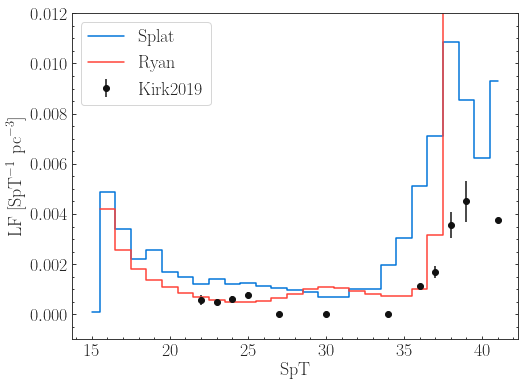

In [18]:
fig, ax=plt.subplots(figsize=(8, 6))
plt.step(grid, sem_emp_phi, color='#0074D9', where='mid', label='Splat')
plt.step(grid, ryan_phi, color='#FF4136', label='Ryan', where='mid')
plt.errorbar(grid, kirk_phi[:,0], yerr=kirk_phi[:,1], fmt='o', c='#111111', label='Kirk2019')
plt.xlabel('SpT', fontsize=18)
plt.ylim([-0.001, 0.012])
plt.minorticks_on()
plt.legend(fontsize=18)
plt.ylabel(r'LF [SpT$^{-1}$ pc$^{-3}$]', fontsize=18)
plt.savefig(wisps.OUTPUT_FIGURES+'/lfs.pdf')